# Machine Learning in Business + Economics

In this project we try to get a grasp of how many research papers in the field of Business and Economics are using machine learning.

In [3]:
import os
import time
import re
import json
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd

## Step 1: Listing NBER WPs

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# start the webdriver
driver = webdriver.Chrome()

# define XPATH queries for data cards
data_card_xpath = (By.XPATH, "//div[@class='digest-card' or @class='digest-card is-new']")

In [3]:
def retrieve_macro_info(element):
    
    # turn into parsable soup
    soup = BeautifulSoup(element.get_attribute('innerHTML'), 'html.parser')
    
    # initialize output dictionary
    out = {}
    
    # retrieve title and link
    tmp = soup.find_all("a", {"href": re.compile("/papers/")})
    out["title"] = tmp[0].text
    out["link"] = tmp[0]["href"]
    out["NBER_ID"] = tmp[1].text
    
    # retrieve authors
    tmp = soup.find_all('a', {"href": re.compile("/people/")})
    out["authors"] = [x.text for x in tmp]
    out["authors_links"] = [x["href"] for x in tmp]
    
    # retrieve date
    out["date"] = soup.find("span").get_text()

    return out

In [4]:
# an element to store the data
data_paged = {}

# loop through the pages
for page in tqdm(range(1, 200)):
    # wait for decency
    time.sleep(1)
    # navigate to the page
    driver.get(f"https://www.nber.org/papers?page={page}&perPage=100&sortBy=public_date")
    # wait for dynamic content to be loaded
    try:
        myElem = WebDriverWait(driver, timeout = 5).until(EC.presence_of_element_located(data_card_xpath))
    except TimeoutException:
        print("Timeout!")
        continue
    # get all data cards
    data_cards = driver.find_elements(*data_card_xpath)
    # loop through the data cards
    data_paged[page] = [retrieve_macro_info(x) for x in data_cards]
    
    # save checkpoint
    if page % 10 == 0:
        with open("nber_data_meta.json", "w") as f:
            json.dump(data_paged, f)

100%|██████████| 199/199 [12:41<00:00,  3.82s/it]


In [17]:
# load the json
with open("data_paged.json", "r") as f:
    data_paged = json.loads(f.read())
# convert keys to integers
data_paged = {int(k): v for k, v in data_paged.items()}
# flatten the dictionary in a dataframe
pd.concat([pd.DataFrame.from_dict(data_paged[i]) for i in range(1, 200)]).to_csv("nber_papers.csv")

## Step 2: Getting abstracts

In [49]:
# get the links
links = pd.read_csv("outstanding_links.csv").link

In [52]:
# an element to store the data
data = {}

# iterate over the links
for index, link in enumerate(tqdm(links)):
    
    # wait for decency
    time.sleep(.5)
    
    # get the page and turn into parsable soup
    try:
        soup = BeautifulSoup(requests.get("https://www.nber.org/" + link).content, 'html.parser')
    except:
        continue
    
    # initialize output dictionary
    out = {}
    
    try:
    
        # retrieve abstract
        out["abstract"] = soup.find("div", {"class": "page-header__intro-inner"}).get_text()
        
        # retrieve acknowledgements and disclosures
        out["a_d"] = soup.find("div", {"id": "accordion-body-guid1"}).p.get_text()
        
        # retrieve auxiliary links
        out["links"] = [x["href"] for x in soup.find_all("a", {"class": "link link--arrow"})]
        
        # retrieve DOI
        out["doi"] = re.sub("\nDOI |\n  ", "", soup.find_all("div", {"class": "page-header__citation-item"})[1].get_text())
        
        # retrieve associated topics and programs
        tmp = soup.find_all("div", {"class": "info-grid__item-body"})
        out["topics"] = tmp[0].find_all(text = True)
        out["programs"] = tmp[1].find_all(text = True)
        
    except:
        pass
    
    # write to list
    data[index] = out
    
    # save checkpoint
    if index % 10 == 0:
        with open("/home/ubuntu/ext_drive/HiWi/mlecon_scraping/ML-in-Business-Economics/nber_data_detailed.json", "w") as f:
            json.dump(data, f)

  4%|▍         | 426/10243 [10:18<3:57:24,  1.45s/it]


KeyboardInterrupt: 

---

In [1]:
def get_data(path):
    # load the json
    with open(path, "r") as f:
        data_paged = json.loads(f.read())

    detailed = pd.DataFrame.from_dict(data_paged, orient = "index").dropna(subset = "doi")
    detailed["id"] = detailed.doi.str.extract(r"((?<=\/\w).*$)")
    detailed["id"] = detailed["id"].apply(int)
    
    return detailed

In [7]:
detailed = pd.concat([get_data("nber_data_detailed.json"), pd.read_csv("nber_detailed.csv")], ignore_index = True)

---

In [12]:
detailed = pd.read_csv("nber_detailed.csv")

In [13]:
meta = pd.read_csv("nber_papers.csv")

In [14]:
merged = pd.merge(meta, detailed, right_on = "id", left_on = "NBER_ID", how = "outer")

In [16]:
merged.to_csv("nber_merged.csv")

---

In [35]:
merged = pd.read_csv("nber_merged.csv")

In [36]:
merged["abstract"] = merged.abstract.str.replace("\n", " ")

In [37]:
merged["year"] = merged.date.str.extract(r"(\d{4})")

In [38]:
search_terms = ["machine.learning",
                "deep.learning",
                "neural.network",
                "artificial.neural.network",
                "artificial.intelligence",
                "reinforcement.learning",
                "(post.){,1}lasso",
                "random.forest",
                "causal.forest",
                "regression.forest",
                "boosted.forest",
                "support.vector.machine"]
search_regex = "|".join([f"({term})" for term in search_terms])
search_regex = f"({search_regex})"

In [39]:
merged["detected"] = (merged.title.str.contains(search_regex, case = False) |
                      merged.abstract.str.contains(search_regex, case = False))

/tmp/ipykernel_7676/3026042317.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merged["detected"] = (merged.title.str.contains(search_regex, case = False) |
/tmp/ipykernel_7676/3026042317.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merged.abstract.str.contains(search_regex, case = False))


In [59]:
merged.dropna(subset = "abstract").loc[:, ["title", "authors", "date", "doi", "abstract", "detected"]].to_csv("output/nber_abstracts.csv")

In [47]:
merged.dropna(subset = "abstract").groupby("year").agg({"detected": "sum", "id": "count"}).\
    rename({"id": "total"}, axis = 1).\
        assign(perc = lambda x: round(x.detected / x.total, 4)).\
            to_csv("output/nber_stats.csv")

<AxesSubplot: xlabel='year'>

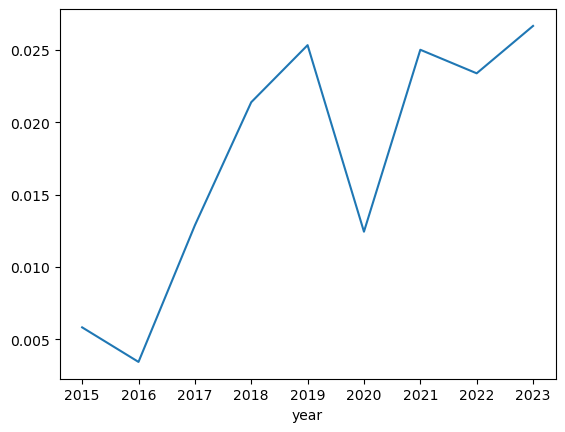

In [42]:
merged.dropna(subset = "abstract").groupby("year").agg({"detected": "sum", "id": "count"}).apply(lambda x: x.detected / x.id, axis = 1).plot()

In [55]:
search_terms = ["regression",
                "linear.regression",
                "logistic.regression",
                "difference.in.difference",
                "natural.experiment"]
search_regex = "|".join([f"({term})" for term in search_terms])
search_regex = f"({search_regex})"

In [56]:
merged["detected"] = (merged.title.str.contains(search_regex, case = False) |
                      merged.abstract.str.contains(search_regex, case = False))

/tmp/ipykernel_7676/3026042317.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merged["detected"] = (merged.title.str.contains(search_regex, case = False) |
/tmp/ipykernel_7676/3026042317.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merged.abstract.str.contains(search_regex, case = False))


In [58]:
merged.dropna(subset = "abstract").groupby("year").agg({"detected": "sum", "id": "count"}).\
    rename({"id": "total"}, axis = 1).\
        assign(perc = lambda x: round(x.detected / x.total, 4)).\
            to_csv("output/nber_stats_regression.csv")

In [ ]:
merged[merged.abstract.isna()].to_csv("outstanding_links.csv")

In [ ]:
# convert keys to integers
data_paged = {int(k): v for k, v in data_paged.items()}
# flatten the dictionary in a dataframe
pd.concat([pd.DataFrame.from_dict(data_paged[i]) for i in range(1, 200)]).to_csv("nber_papers.csv")